In [1]:
import numpy as np
from modules import node, sensing, system
from modules import optimization as opt
from configs import config
from scipy.linalg import svd, qr
import matplotlib.pyplot as plt
from typing import Iterable, Dict, Any

noise_power = config.NOISE_POWER

In [2]:
def _spectral_norm(M: np.ndarray) -> float:
    return float(np.linalg.norm(M, 2))

def _rth_singular_value(M: np.ndarray, r: int) -> float:
    # Use eigen decomposition for symmetric; fall back to SVD otherwise
    if np.allclose(M, M.T, atol=1e-12):
        w = np.linalg.eigvalsh(M)              # ascending
        s = np.sort(np.abs(w))[::-1]           # |eig| == singular vals for symmetric
    else:
        s = np.linalg.svd(M, compute_uv=False)
    if not (1 <= r <= len(s)):
        raise ValueError(f"r must be in [1, {len(s)}], got r={r}.")
    return float(s[r-1])

def _top_r_subspace(M: np.ndarray, r: int) -> np.ndarray:
    # Returns N x r orthonormal basis U for the top-r singular subspace of M
    if np.allclose(M, M.T, atol=1e-12):
        w, Q = np.linalg.eigh(M)               # ascending
        idx = np.argsort(np.abs(w))[::-1][:r]
        U = Q[:, idx]
    else:
        U, *_ = np.linalg.svd(M, full_matrices=False)
        U = U[:, :r]
    U, _ = np.linalg.qr(U)                     # re-orthonormalize
    return U

def mu0_incoherence(M: np.ndarray, r: int) -> float:
    """
    μ0(M) = (N / r) * max_i ||U[i,:]||^2 where U spans the top-r singular subspace.
    """
    N = M.shape[0]
    if not (1 <= r <= N):
        raise ValueError("r must be between 1 and N.")
    U = _top_r_subspace(M, r)
    row_norm_sq = np.sum(U**2, axis=1)         # length-N
    return float((N / r) * np.max(row_norm_sq))

# ---------- Dimensionless ratio ----------
def compute_dimensionless_ratios(
    M_star: np.ndarray,
    w_star: np.ndarray,
    M_seq: Iterable[np.ndarray],
    r: int,
) -> Dict[str, Any]:
    """
    Compute Xi_t and bar_Xi for Assumption-4-in-big-O form.

    Inputs
    ------
    M_star : (N,N) symmetric PSD (rank ~ r is typical, but not strictly required).
    w_star : (N,) vector
    M_seq  : iterable of (N,N) matrices  {M_t}
    r      : target rank used in analysis

    Returns
    -------
    dict with keys:
      - Xi_each_t  : list[float], the Xi_t per iteration t
      - bar_Xi     : float, max Xi_t
      - mu0_each_t : list[float], μ0(M_* - M_t) per t
      - scale      : float, r (||M_*||_2 + ||w_*||_2) / (N * σ_r(M_*))
      - sigma_r_Mstar, norm_Mstar_2, norm_wstar_2, N, r
    """
    N = M_star.shape[0]
    sigma_r = _rth_singular_value(M_star, r)
    norm_M = _spectral_norm(M_star)
    norm_w = float(np.linalg.norm(w_star, 2))
    scale = (r * (norm_M + norm_w)) / (N * sigma_r)

    Xi_list, mu_list = [], []
    for Mt in M_seq:
        Delta = M_star - Mt
        mu = mu0_incoherence(Delta, r)
        Xi = scale * mu
        mu_list.append(float(mu))
        Xi_list.append(float(Xi))

    return dict(
        Xi_each_t=Xi_list,
        bar_Xi=max(Xi_list) if Xi_list else 0.0,
        mu0_each_t=mu_list,
        scale=float(scale),
        sigma_r_Mstar=float(sigma_r),
        norm_Mstar_2=float(norm_M),
        norm_wstar_2=float(norm_w),
        N=int(N),
        r=int(r),
    )

In [3]:
def run(N):
    B, r = 10 * N, 2
    M_seq = []

    tx = node.TX(x=0, y=0, z=10)
    rx = node.RX(x=50, y=50, z=1.5)
    ris = node.RIS(x=10, y=50, z=2, N=N)

    sys = system.System(tx, ris, rx)

    # generate a channel h
    sys.gen_channels(is_los=False)

    # sending samples and collect observation:
    N_samples = N * 100
    X = np.zeros(shape=(sys.ris.N, N_samples))
    y = np.zeros(shape=(N_samples, 1))

    for i in range(N_samples):
        # generate a random ris setting
        sys.ris.set_random_binary_phase_shifts()
        x = sys.ris.vector_x
        X[:, i] = x.flatten()
        y[i] = sys.cal_snr() - sys.c_true

    def compute_A(X, M):
        # A_i(M) = x_i.T @ M @ x_i
        # shape of X: N x B
        # A(M) should be a column vector, shape B x 1
        B = X.shape[1]
        return np.array([X[:, i].T @ M @ X[:, i] for i in range(B)]).reshape(-1, 1)

    def compute_A_adj(z, X):
        # compute adjoint operator = 1/2/B * sum (z_i * x_i * x_i.T)
        # z is a column vector
        # return a matrix whose shape N x N
        B = X.shape[1]
        sum = 0
        for i in range(B):
            sum += z[i, 0] * X[:, i].reshape(-1, 1) @ X[:, i].reshape(-1, 1).T
        return sum
    
    # Initialization using the first mini batch
    w = np.zeros((N, 1))
    V = np.zeros((N, r))
    X_init = X[:, :B]
    y_init = y[:B]
    M_init = np.zeros((N, N))
    A_M_init = compute_A(X=X_init, M=M_init)
    r_vec = y_init - A_M_init - X_init.T @ w
    H1_init = compute_A_adj(r_vec, X_init)
    h2_init = np.mean(r_vec)
    matrix_init = H1_init - 0.5 * h2_init * np.eye(N)
    U_init, _, _ = svd(matrix_init)
    U = U_init[:, :r]

    all_norms = [] # store the norm of M + the norm of w, to confirm convergence
    i = 0
    perm_count = 0 # count how many times we shuffle the data
    # compute each mini-batch
    while True:
        # current batch data
        start = i * B
        end = start + B
        X_t = X[:, start:end]
        y_t = y[start:end]
        
        # this is the current M computed using U and V from previous batch
        M = 0.5 * (U @ V.T + V @ U.T)
        M_seq.append(M)
        
        A_M = compute_A(X=X_t, M=M)
        r_t = y_t - A_M - X_t.T @ w

        H1 = 1/2/B * compute_A_adj(z=r_t, X=X_t)
        h2 = np.mean(r_t)
        h3 = 1/B * X_t @ r_t

        matrix_update = H1 - 0.5 * h2 * np.eye(N) + M.T
        U_hat = matrix_update @ U
        U, _ = qr(U_hat, mode='economic')

        w = w + h3
        V = matrix_update @ U

        # store the sum of norm
        all_norms.append(np.linalg.norm(M) + np.linalg.norm(w))
        i += 1
        if i * B + B > len(y):
            perm = np.random.permutation(len(y))
            perm_count += 1
            X = X[:, perm]
            y = y[perm]
            i = 0
        var = np.var(all_norms[-5:])
        if  var > 0 and var < 10**-3:
            break
        if perm_count == 10:
            print(f'Variance of the last 5 estimates = {var}')
            print('Consider to increase the batch size or number of samples.')
            break

    return 1/compute_dimensionless_ratios(M_star=sys.M_true, w_star=sys.w_true, M_seq=M_seq[1:], r=2)['bar_Xi']

In [5]:
N_trials = 1000 #number of running time
N = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
res = np.zeros(shape=(N_trials, len(N)))

for i in range(len(N)):
    print(f'Processing N = {N[i]}')
    data = np.array([run(N[i]) for j in range(N_trials)])
    res[:, i] = data

mean = np.array([np.mean(res[:, i]) for i in range(len(N))])
std = np.array([np.std(res[:, i]) for i in range(len(N))])

Processing N = 10
Processing N = 20
Processing N = 30
Processing N = 40
Processing N = 50
Processing N = 60
Processing N = 70
Processing N = 80
Processing N = 90
Processing N = 100
Processing N = 110
Processing N = 120
Processing N = 130
Processing N = 140
Processing N = 150


In [8]:
N   = np.insert(N,   0, 0)
mean= np.insert(mean,0, 0.0)
std = np.insert(std, 0, 0.0)

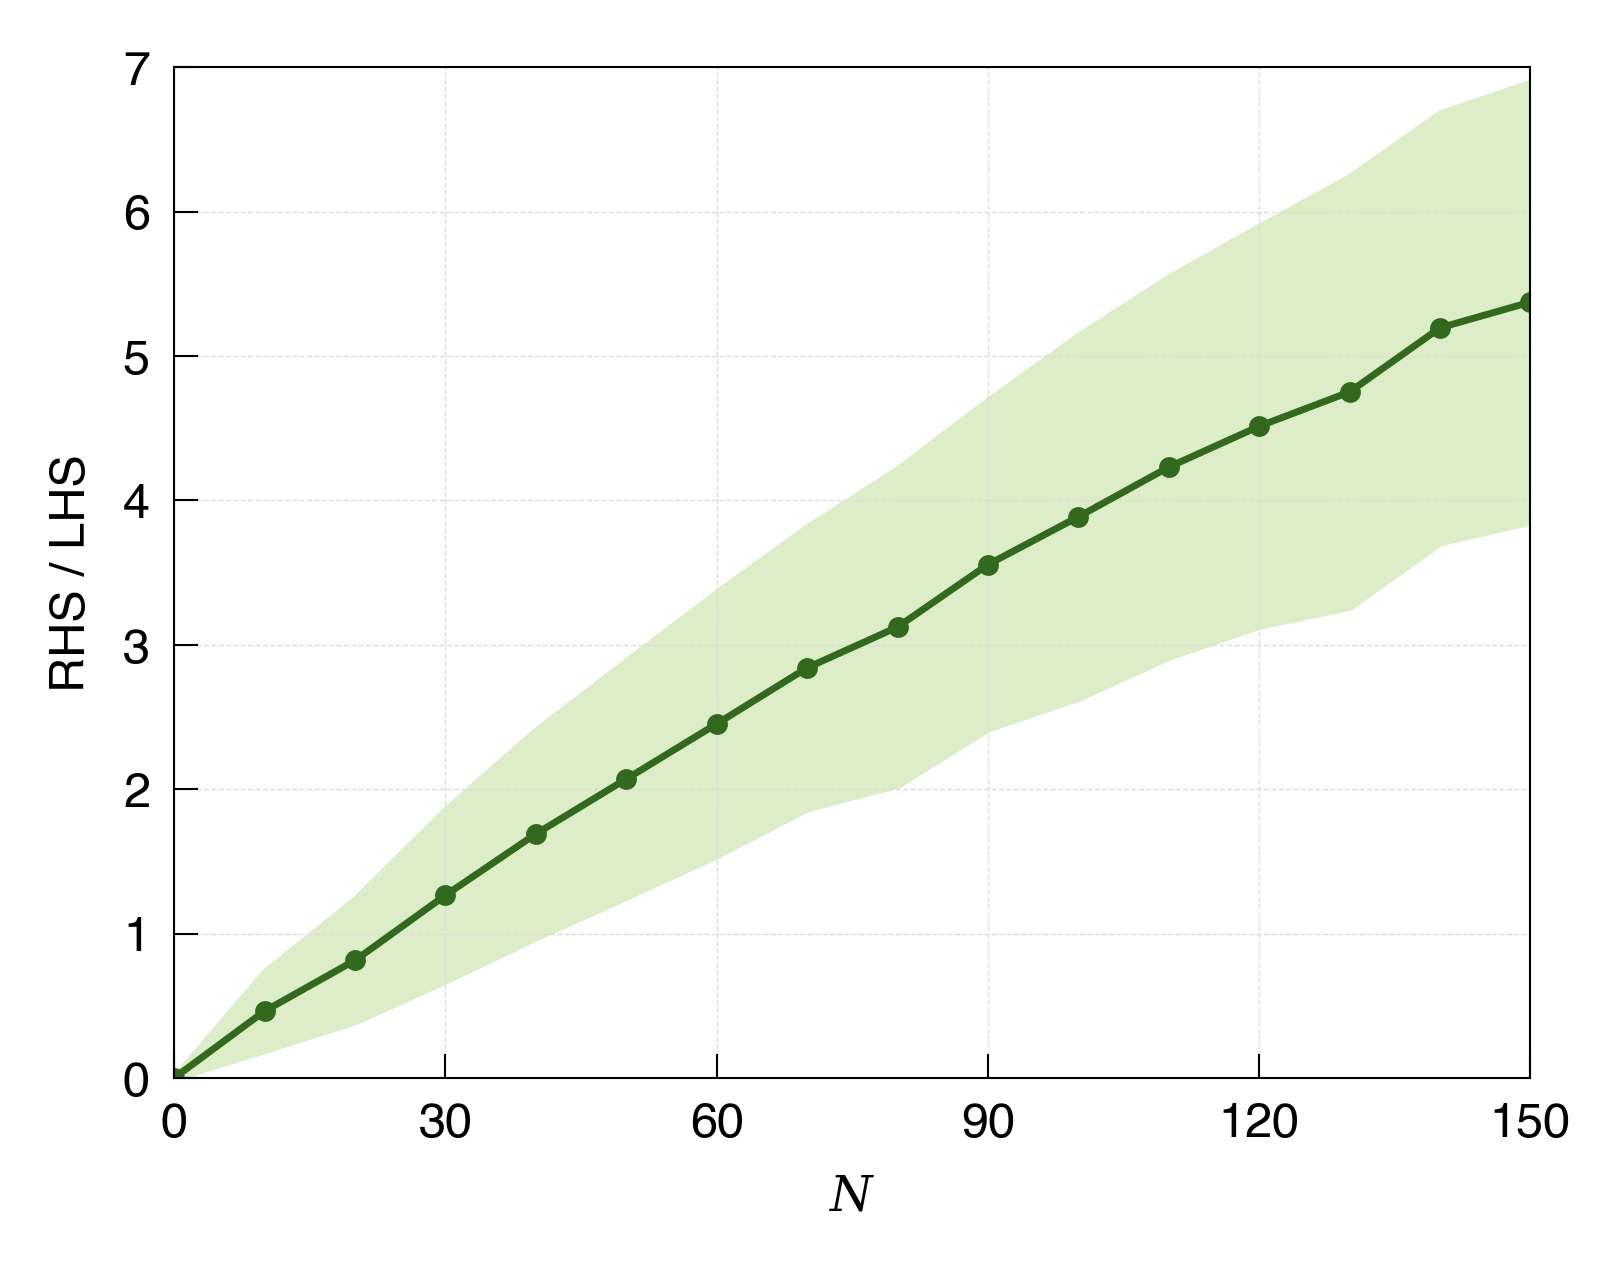

In [13]:
colors = ['#B71C1C', '#039BE5', '#26A69A', '#FF6F00', '#616161', '#BA68C8', '#EC407A']
plt.figure(figsize=(3.5, 2.625), dpi=500)
#Font setup
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 7
plt.rcParams['legend.fontsize'] = 7

plt.rcParams['xtick.minor.visible'] = False
plt.rcParams['ytick.minor.visible'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 0.3
plt.rcParams['ytick.major.width'] = 0.3
plt.rcParams['axes.linewidth'] = 0.3

plt.plot(N, mean, marker='o', markersize='2.0', color='#33691E', linewidth=1.0, ls='-')
plt.fill_between(N, mean - std, mean + std, color='#DCEDC8' )

plt.xlabel(r'$N$')
plt.ylabel(r'RHS / LHS')
plt.xlim([10, 150])
plt.ylim([0, 7])
plt.xticks([0, 30, 60, 90, 120, 150])
# leg = plt.legend(frameon=True, edgecolor='black', framealpha=0.8)
# leg.get_frame().set_linewidth(0.4)
plt.grid(color='gainsboro', linestyle='--', linewidth=0.2)
plt.savefig('fig_verify_assumption.pdf', dpi=500, bbox_inches='tight', pad_inches=0.05)